# Access and mosaic Planet NICFI monthly basemaps

> A guide for accessing monthly Planet NICFI basemaps, selecting data by a defined AOI and mosaicing to produce a single image. 

You will need a configuration file named `planet_api.cfg` (simple text file with `.cfg` extension will do) to run this notebook. It should be located in your `My Drive` folder.

The contents of the file should reflect the template below, swapping in the API access key that you should have receieved once you signed up for and subscribed to the Planet NICFI program. Please visit https://www.planet.com/nicfi/ to sign up if you have not already. 



```
[credentials]
api_key = xxxxxxxxxxxxxxxxx
```






## Setup Notebook

```{admonition} **Version control**
Colab updates without warning to users, which can cause notebooks to break. Therefore, we are pinning library versions.
``` 

In [ ]:
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2
!pip install -q shapely==1.8.0

In [ ]:
# import required libraries
import os, glob, functools, fnmatch, requests, json
from zipfile import ZipFile
from itertools import product
from configparser import ConfigParser
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd
from folium import Map, GeoJson, Figure
from shapely.geometry import box

from IPython.display import clear_output

In [ ]:
print("rasterio version: ", rasterio.__version__, "| geopandas version: ", gpd.__version__)

rasterio version:  1.2.10 | geopandas version:  0.10.2


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Set your root directory, and project level directories.
root_dir = '/content/gdrive/My Drive/servir-tf-devseed/' 
terrabio_dir = root_dir+'terrabio'
rami_dir = root_dir+'rami'

In [ ]:
# Make subdirectories for each project
dirs = [terrabio_dir, rami_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
# Go to root folder
%cd $root_dir

/content/gdrive/MyDrive/servir-tf/data/servir-tf-devseed


```{admonition} **GCS note!**
We won't be using Google Cloud Storage to download data, but here is a code snippet to show how to practically do so with the RAMI "Blocks" gridded AOI shapefile. This code works if you have access to the "servirtensorflow" project on GCP.
```

```python
#authenticate Google Cloud Storage
from google.colab import auth
auth.authenticate_user()
print("Authenticated Google Gloud access.")


# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
project = 'servirtensorflow'
storage_client = storage.Client(project=project)

# The name for the new bucket
bucket_name = "dev-seed-workshop"

rami_data_dir = rami_dir+'/data/'
rami_gcs_to_local_dir = rami_data_dir+'gcs/'
prefix = 'rami/data/Blocks/'
local_dir = rami_gcs_to_local_dir+'Blocks/'
dirs = [rami_data_dir, rami_gcs_to_local_dir, local_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)


bucket_name = "dev-seed-workshop"
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    print(blob)
    filename = blob.name.replace('/', '_') 
    filename_split = os.path.splitext(filename)
    filename_zero, fileext = filename_split
    basename = os.path.basename(filename_zero)
    filename = 'Blocks'
    blob.download_to_filename(local_dir + filename + fileext)  # Download
    print(blob, filename + fileext)

```
Output:
```
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.cpg, 1637264951785014>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.cpg, 1637264951785014> Blocks.cpg
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.dbf, 1637264951817858>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.dbf, 1637264951817858> Blocks.dbf
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.fix, 1637264951832266>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.fix, 1637264951832266> Blocks.fix
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.prj, 1637264951801837>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.prj, 1637264951801837> Blocks.prj
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shp, 1637264951794288>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shp, 1637264951794288> Blocks.shp
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shx, 1637264951768348>
<Blob: dev-seed-workshop, rami/data/Blocks/Blocks/Blocks.shx, 1637264951768348> Blocks.shx
````

### Get search parameters
- Read the AOI from the shared google drive folder into a Geopandas dataframe.
- Get AOI bounds and centroid.
- Authenticate with Planet NICFI API key.
- Choose mosaic based on month/year of interest.


In [ ]:
# Inspect contents of RAMI "Blocks" gridded AOI folder
!ls Blocks/

Blocks.cpg  Blocks.dbf	Blocks.fix  Blocks.prj	Blocks.shp  Blocks.shx


In [ ]:
# Load the shapefile into a geopandas dataframe (for more info see: https://geopandas.org/en/stable/)
gdf = gpd.read_file('Blocks/Blocks.shp')
# Get AOI bounds
bbox_peru = gdf.geometry.total_bounds
# Get AOI centroid
centroid_peru = [box(*bbox_peru).centroid.x, box(*bbox_peru).centroid.y]

In [ ]:
# authenticate with Planet NICFI API KEY
config = ConfigParser()
configFilePath = '/content/gdrive/My Drive/planet_api.cfg'
with open(configFilePath) as f:
    config.read_file(f)
API_KEY = config.get('credentials', 'api_key')
PLANET_API_KEY = API_KEY # <= insert API key here 
#setup Planet base URL
API_URL = "https://api.planet.com/basemaps/v1/mosaics"
#setup session
session = requests.Session()
#authenticate
session.auth = (PLANET_API_KEY, "") #<= change to match variable for API Key if needed

```{important}
In the following cell, the **name__is** parameter is the basemap name. It is only differentiable by the time range in the name.

E.g. `planet_medres_normalized_analytic_2021-08_mosaic` is for August, 2020.

 
```

In [ ]:
#set params for search using name of mosaic
parameters = {
    "name__is" :"planet_medres_normalized_analytic_2021-08_mosaic" # <= customized to month/year of interest
}
#make get request to access mosaic from basemaps API
res = session.get(API_URL, params = parameters)
#response status code
print(res.status_code)

200


In [ ]:
#print metadata for mosaic
mosaic = res.json()
#print("mosaic metadata (this will expose your API key so be careful about if/where you uncomment this line): ", json.dumps(mosaic, indent=2))

In [ ]:
#get id
mosaic_id = mosaic['mosaics'][0]['id']
#get bbox for entire mosaic
mosaic_bbox = mosaic['mosaics'][0]['bbox']
print("mosaic_bbox: ", mosaic_bbox)
print("bbox_peru: ", bbox_peru)
#converting bbox to string for search params
string_bbox = ','.join(map(str, bbox_peru)) #bbox_peru)) #mosaic_bbox))

print('Mosaic id: '+ mosaic_id)

mosaic_bbox:  [-179.999999974944, -30.145127179527, 179.999999975056, 30.145127179625]
bbox_peru:  [-70.28418783 -13.07947054 -69.78113127 -12.75607703]
Mosaic id: ce7bad0f-a4a0-45fd-904b-eb6cc6eee373


#### Plot the gridded AOI. 

In [ ]:
m = Map(tiles="Stamen Terrain",
        control_scale=True,
        location = centroid_peru,
        min_lon=-70.28418783,
        max_lon=-69.78113127,
        min_lat=-13.07947054,
        max_lat=-12.75607703,
        max_bounds=True,
        zoom_start = 10,
        max_zoom = 8,
        min_zoom =6,
        width = '100%',
        height = '100%',
        zoom_control=False )
GeoJson(gdf).add_to(m)
Figure(width=500, height=300).add_child(m)

### Request the quad tiles fitting the search parameters

In [ ]:
#search for mosaic quad using AOI
search_parameters = {
    'bbox': string_bbox,
    'minimal': True
}
#accessing quads using metadata from mosaic
quads_url = "{}/{}/quads".format(API_URL, mosaic_id)
res = session.get(quads_url, params=search_parameters, stream=True)
print(res.status_code)

200


In [ ]:
quads = res.json()

In [ ]:
quads = res.json()
items = quads['items']
#printing an example of quad metadata
#print("quad tiles metadata (this will expose your API key so be careful about if/where you uncomment this line): ", json.dumps(items[0], indent=2))

#### Plot the requested quad tiles. 

In [ ]:
for item, i in zip(items, range(len(items))):
  quad_box = item["bbox"]
  GeoJson(box(*quad_box)).add_to(m)
Figure(width=500, height=300).add_child(m)

In [ ]:
# Set directory for downloading the quad tiles to
nicfi_dir = rami_dir+'/082021_basemap_nicfi_lapampa/' 
quads_dir = nicfi_dir+'/quads/'
dirs = [nicfi_dir, quads_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
#iterate over quad download links and saving to folder by id
for i in items:
    link = i['_links']['download']
    name = i['id']
    name = name + '.tiff'
    DIR = quads_dir
    filename = os.path.join(DIR, name)
    #print(filename)

    #checks if file already exists before s
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(link, filename)

### Mosaic the quad tiles

In [ ]:
# File and folder paths
out_mosaic = nicfi_dir+'082021_basemap_nicfi_lapampa_Mosaic.tif'

# Make a search criteria to select the quad tile files
search_criteria = "*.tiff"
q = os.path.join(nicfi_dir,'quads', search_criteria)

print(q)

/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/*.tiff


In [ ]:
# Get all of the quad tiles
quad_files = glob.glob(q)

In [ ]:
quad_files

['/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/624-950.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/625-950.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/626-950.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/627-950.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/624-949.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/625-949.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/626-949.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/627-949.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/624-948.tiff',
 '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/quads/625-948.tiff',


In [ ]:
src_files_to_mosaic = []

In [ ]:
for f in quad_files:
  src = rasterio.open(f)
  src_files_to_mosaic.append(src)

In [ ]:
# Create the mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans
                  }
)

In [ ]:
# Write the mosaic to raster file
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
out_mosaic

'/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'

In [ ]:
!ls '/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'

'/content/gdrive/My Drive/servir-tf-devseed/rami/082021_basemap_nicfi_lapampa/082021_basemap_nicfi_lapampa_Mosaic.tif'


#### Plot the mosaic

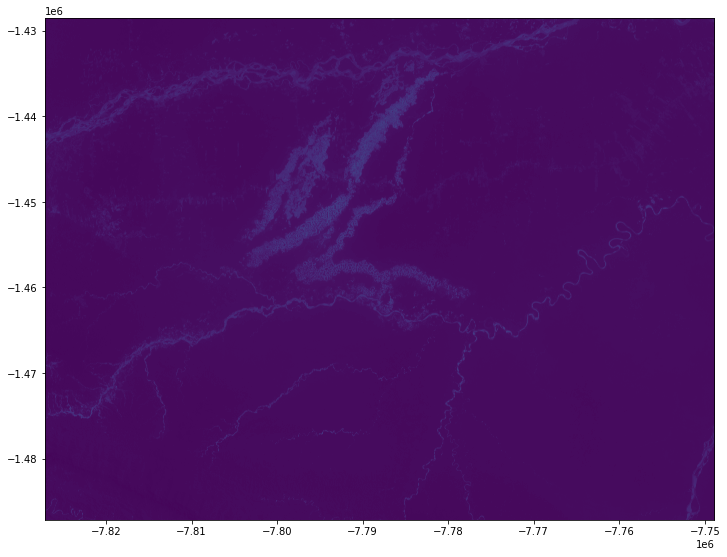

In [ ]:
src = rasterio.open(out_mosaic)

show(src)